# Technical Notes for SSD

In [1]:
# Common imports
import pandas as pd
import numpy as np
import tensorflow as tf 
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# to make this notebook's output stable across runs
np.random.seed(42)

### SSD: Single-Shot-Multibox Detector https://arxiv.org/pdf/1512.02325.pdf

Early layers use a standard network called the "base network"which is VGG16 in the paper.

The later layers add structure that have the following features: they are set up such that intuitively large fine-grained feature maps at earlier levels are good at capturing small objects and later small coarse-grained feature maps can detect large objects well.

SSD produces a feed-forward computational network that produces a fixed sized collection of bounding boxes and scores for the presence of the object class instances in those boxes. 

**Convolutional predictors for detection**
 - Each added feature layer is size $m\times n$ with $p$ channels.
 - Small convnet kernel size $3\times 3 \times p$ is used to predict the detection and produces either a score for a category, or a shape offset relative to the default box coordinates. Note, the default box that is used in the paper is the same as the "anchor" box used in other papers. At each of the $m\times n$ locations where the kernel is applied, it produces an output value.
 - The bounding box offset output values are measured relative to a default box position relative to each feature map cell.
 
**Default boxes and aspect ratios**
 - Associate a set of default bounding boxes with each feature map cell for multiple feature maps at the top of the network.
 - The default boxes tile the feature map in a convolutional manner, so that the position of each box relative to its corresponding cell is fixed. At each feature map cell, we predict the offsets relative to the default box shapes in the cell, as well as the per-class scores that indicate the presence of a class instance in each of those boxes.
 
<img src='ssd_images/ssd_dog.png'>

 - The training data contains images with *ground truth* boxes for every object as shown in (a) above. The feature map is $8\times8$ with default boxes of different aspect ratios which correspond to a smaller area of the raw input shown in (b) above. In a coarse-grained feature map $4\times4$, the default boxes cover larger area of the raw input as shown in (c).
 - There are $k$ default boxes, for each default box we calculate $c$ class scores and $4$ offsets relative to the original default box. 
 - For each default box, we predict both the shape offsets: $\Delta(c_x, c_y, w, h)$. $c_x, c_y$ correspond to the center of the default boxes and $w,h$ are the width and height  
 - The confidences for all $p$ object categories: $(c_1, c_2, · · · , c_p)$. 
 - The width, height and the center location of the default boxes are all normalized to be between $\left(0, 1\right)$.
 - At a location $i,j$ of the $l$th feature layer of size $m\times n$ where $i=0,1,...,m$; $j=0,1,...,n$.
 - The aspect ratios, $r$, that we use are $r\in\{1,2,3,1/2,1/3\}$
      -  We can compute a unique linear scale proportional to the layer lavel. Suppose we have $l = 0, 1, ..., L$ feature layers, then the scale of the default boxes is calculated as (linear interpolation between $s_{min}$ and $s_{max}$):
      $s_l = s_{min} + \frac{s_{max} - s_{min}}{L-1}(l-1)$ where $s_{min}=0.2$ and $s_{max}=0.9$.
      - An additional default box is constructed when the aspect ratio is 1, where the scale is calculated as 
      $s_{l}' = \sqrt{s_{l}s_{l}+1}$  
      
  <img src="ssd_images/SSD-box-scales.png">
      - Figure above shows how the default box size is scaled up with the layer.  
      - Per feature layer, we can calculate the width and height of our default boxes given our aspect ratios and calulated scales:
      $w_{l}^{r} = s_l\sqrt{r}$, $h_{l}^{r} = \frac{s_l}{\sqrt{r}}$.
      - We therefore, have five different default box aspect ratios (width-to-height ratios), in addition to a special scale when the aspect ratio is 1. This gives us $\mathbb{6}$ total default boxes per feature layer cell. 
 - The center of each default box is then set to: $\frac{i+0.5}{|f_l|}, \frac{j+0.5}{|f_l|}$ where $|f_l|$ is the size of the $l$-th square feature map. In this case for our $\
 m\times n$ feature map the center of each default box is $\frac{i+0.5}{m}, \frac{j+0.5}{n}$. This is just a normalization since we have constrained the default boxes to be $(0,1)$.
 
*Summarizing*:
- A feature layer (map) of size $m\times n$ where $i=0,1,...,m$, $j=0,1,...,n$. The size of the feature layer is normalized to $(0,1)$. Note, in the implementation in the paper used square feature maps so $m=n$. 

- There are $L$ feature layers, the lower layers will use larger feature maps, whereas the higher layers will use smaller ones. 

- Aspect ratios, $r$: 
<br> $r\in\{1,2,3,1/2,1/3\}$

- For a feature layer, $l$, the scale of the default boxes, $s_l$: <br> $s_l = s_{min} + \frac{s_{max} - s_{min}}{L-1}(l-1)$ where $l = 0, 1, ..., L$.

- Scale of the additional default box, $s_{l}'$: <br> $s_{l}' = \sqrt{s_{l}s_{l}+1}$ 

- For a feature layer scale, $s_l$, and aspect ratio, $r$, the width of the default boxes are, $w_{l}^{r}$: <br> $w_{l}^{r} = s_l\sqrt{r}$

- For a feature layer scale, $s_l$, and aspect ratio, $r$, the height of the default boxes are, $h_{l}^{r}$: <br> $h_{l}^{r} =\frac{s_l}{\sqrt{r}}$

- For a $m\times n$ feature layer, the center of the default box, $c_x,c_y$:
<br> $c_x = \frac{i+0.5}{m},c_y=\frac{j+0.5}{n}$

Finally, at every location, the model outputs 4 shape offsets $\Delta(c_x, c_y, w, h)$ and $c$ class probabilities by applying a $3\times3\times p$ convolutional filter (where $p$ is the number of channels in the feature map) for every one of $k$ ($6$ in the paper) default boxes. Result is $(c+4)k$ filters applied around each location in the feature map. Therefore, a feature map of size $m\times n$, yields a $(c+4)kmn$ output, which is the output tensor depth.
 

** Datasets Used for training **
- PASCAL, VOC, COCO, ILSVRC

**Training**

Let $p$ be the number of object categories. 

Let $x_{ij}^p=\{1,0\}$ be the indicator function for matching the $i$-th default box coordinates to the $j$-th ground truth box coordinates  for a category $p$ (note that these are different $i$ and $j$ indices than the ones used for the feature map size). 

We can also express this indicator function as $\mathbb{1}_{ij}^{match}=\{1,0\}$.

The indicator function will be calculated according to the threshold set for the Jaccard coefficient calculated between the default box and ground truth box for category $p$.

Similar to YOLO, the objective or loss function is defined as: 

$L(x, c, l, g)=\frac{1}{N}(L_{conf}(x,c) + \alpha L_{loc}(x,l,g))$

where 
 - $L(x, c, l, g)$ is the total loss
 
 - $N$ is the number of matched bounding boxes
 
 - $L_{conf}(x,c)$ is the classification loss that depends on the indicator function matching, $x_{ij}^p$, and object confidence, $c$.
 
 - $L_{loc}(l,g)$ is the localization loss that depends on the predicted box, $l$, and the ground truth box, $g$.

 - $\alpha$ is the hyperparameter for weighting the 2 losses, this can be determined by cross validation and is set to $1$ in the paper. 
 


*Localization loss*

$L_{loc}(x,l,g) = \sum_{i,j}\sum_{m\in\{c_x,c_y,w,h\}}\hspace{0.1cm}x_{ij}^k\text{smooth}_{L1}(l_{i}^m - t_{j}^m)$

where 
 - $\text{smooth}_{L1}$ is a smooth $L1$ loss function
 - $x_{ij}^k$ is the indicator function that matches the $i$th default box coordinates $(d_{i}^{c_x},d_{i}^{c_y}, d_{i}^{w}, d_{i}^{h})$ and the $j$th ground truth box coordinates, $(g_{i}^{c_x},g_{i}^{c_y}, g_{i}^{w}, g_{i}^{h})$  for any $k$th object category. 
 - $l_{i}^m$ are the *predicted* correction coordinates for default box, $i$, where $m\in\{c_x,c_y,w,h\}$
 - $t_{j}^m$ is the *target* or estimated coordinates for the ground truth box, $j$, where $m\in\{c_x,c_y,w,h\}$ (note that $\hat{g}_{j}^m$ is used in the paper). 

The $\text{smooth}_{L1}$ is defined by:

$\begin{equation}
  \text{smooth}_{L1}(x) =
    \begin{cases}
      0.5x^2 & \text{if}\hspace{0.1cm}|x|< 1\\|x|-0.5 & \hspace{0.1cm}\text{otherwise}\\
    \end{cases}       
\end{equation}$

This smoothed version of a $L1$ is used since a purely quadratic loss ($L2$) can be dominated by outliers and so the smoothed version is less sensitive to outliers. More information about the smooth $L1$ loss can be found here: 

https://github.com/rbgirshick/py-faster-rcnn/files/764206/SmoothL1Loss.1.pdf  

The localization loss is made between the *predicted* default box correction values and the *target* ground truth values. This is similar to *bounding-box regression* where $L2$ regression is configured to learn scale-invariant transformations between two bounding box centers and log-scale transformation between widths and heights. The predicted corrections, $l_{i}^{m}$, where $i\in\{x,y,w,h\}$, can take any value between $[-\infty, +\infty]$. The targets for them to learn are the following:
 
 $t_{j}^{c_x} = \frac{(g_{j}^{c_x} - d_{i}^{c_x})}{d_{i}^w}$
 
 $t_{j}^{c_y} = \frac{(g_{j}^{c_y} - d_{i}^{c_y})}{d_{i}^h}$
 
 $t_{j}^{w} = \log(\frac{g_{j}^w}{d_{i}^w})$
 
 $t_{j}^{h} = \log(\frac{g_{j}^h}{d_{i}^h})$
 
 The can be depicted roughly in the picture below:

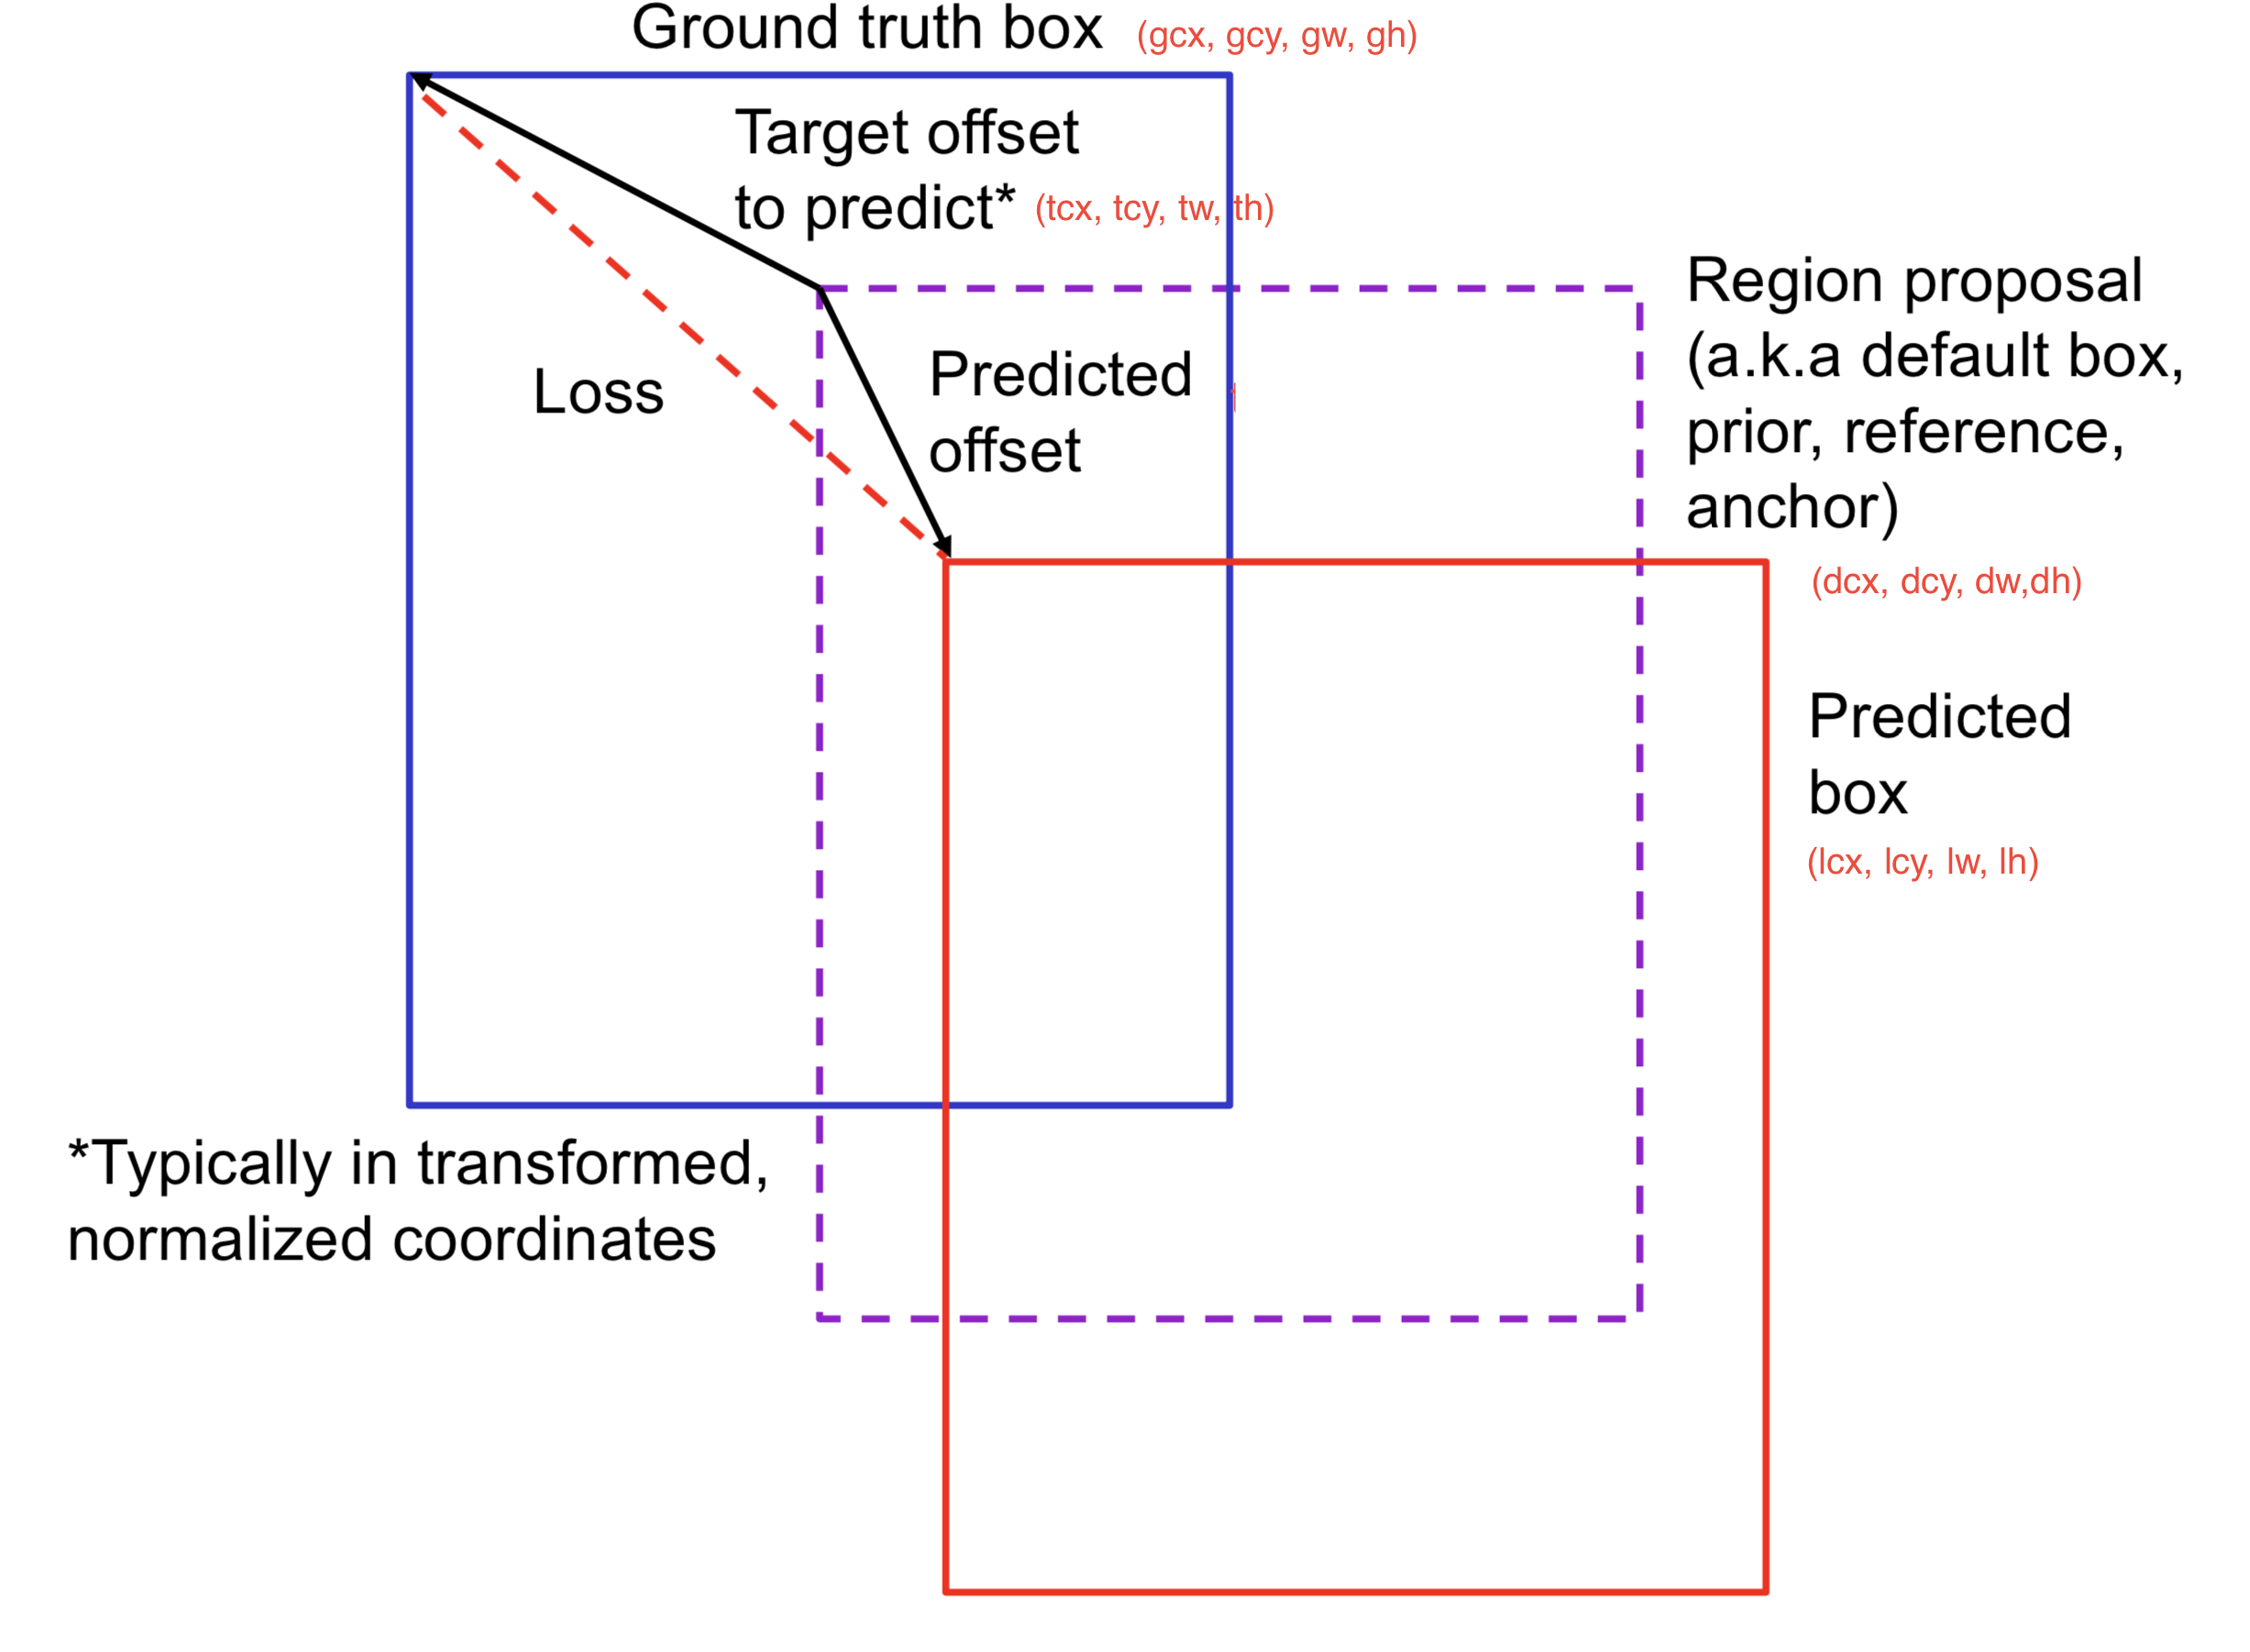
 

*Confidence loss*

The confidence loss is the softmax loss over multiple class confidences ($c$).

$L_{conf}(x,c) = -\sum_{i\in Positive}^N \hspace{0.1cm}x_{ij}^p\log(\hat{c}_i^p)-\sum_{i\in Negative}\log(\hat{c}_i^o)$

where 
$\hat{c}_i^p=\frac{\exp(c_i^p)}{\sum_p\exp(c_i^p)}$

and $x_{ij}^p$ indicates whether the $i$th default box and the $j$th ground truth box are matched for an object in class $p$. $Positive$ is the set of matched bounding boxes ($N$ items in total) and $Negative$ is the set of negative examples.

The dog in the figure above is matched to a default box in the $4\times4$ feature map but no default boxes in the $8\times8$ feature map and so those boxes are considered as negatives during training. 
After the matching step most of the default boxes are $Negative$ which creates a large imbalance between positive and negative training examples.  

A solution to this imbalance that SSD utilizes is called *hard negative mining*. Easily misclassified negative examples are selected to construct the $Negative$ set. Once all the default boxes are sorted by object confidence score, the model picks the top candidates for training so that $Negative:Positive$ is at most $3:1$.

**Data Augmenentation** 

Each training image is randomly sampled by one of the following options:
 - use the entire image 
 - sample the patch so the *minimum* jaccard overlap with an object is $0.1, 0.3, 0.5, 0.7, 0.9$. 
 - Randomly sample a patch
 
The size of each sampled patch is $[0.1, 1]$ of the original image size, and the aspect ratio is between $\frac{1}{2}$ and $2$. The overlapped part of the ground truth box is kept if the center is in the sample patch.  After the aforementioned sampling step, each sampled patch is resized to fixed size and is horizontally flipped with probability of $0.5$, in addition to applying some photo-metric distortions.

**Results & Discussion**

<img src="ssd_images/ssd_arch.png">

The base network VGG-16 is pretrained on the ILSVRC CLS-LOC dataset. Layers fc6 (fully-connected) and fc7 are converted to convolutional layers, subsample parameters from fc6 and fc7, change pool5 from $2\times2 − s2$ (stride of $2$) to $3\times3 − s1$, and use the atrous algorithm to fill the ”holes”. Please see below for an explaination of the atrous algorithm. 

All the dropout layers and the fc8 layer are removed. We fine-tune the resulting model using SGD with initial learning rate $10^{−3}$, $0.9$ momentum, $0.0005$ weight decay, and batch size $32$. 

SSD can detect various object categories with high quality. The majority of its confident detections are correct. The recall is around $85-90$%, and is much higher with “weak” ($0.1$ jaccard overlap) criteria. Compared to R-CNN , SSD has less localization error, indicating that SSD can localize objects better because it directly learns to regress the object shape and classify object categories instead of using two decoupled steps. 

However, SSD has more confusions with similar object categories (especially for animals), partly because we share locations for multiple categories. 

SSD is also very sensitive to the bounding box size. In other words, it has much worse performance on smaller objects than bigger objects. This is not surprising because those small objects may not even have any information at the very top layers. Increasing the input size (e.g. from $300\times300$ to $512\times512$) can help improve detecting small objects, but there is room to improve. On the positive side, we can clearly see that SSD performs really well on large objects. And it is very robust to different object aspect ratios because we use default boxes of various aspect ratios per feature map location

Data augmentation is crucial. The data augmentation strategy described  helps to improve the performance dramatically, especially on small datasets

More default box shapes is better. There are 6 default boxes per location. 

Atrous is faster. A atrous version of a subsampled VGG-16 following DeepLab-LargeFOV is used. If we use the full VGG16, keeping pool5 with $2\times2 − s2$ and not subsampling parameters from fc6 and fc7, and add conv5_3 for prediction, the result is about the same while the speed is about $20$% slower.

Multiple output layers at different resolutions is better. A major contribution of SSD is using default boxes of different scales on different output layers. Because we have more training images by introducing this new ”expansion” data augmentation trick, we have to double the training iterations. We have seen a consistent
increase of $2$%-$3$% mAP across multiple datasets.

An alternative way of improving SSD is to design a better tiling of default boxes so
that its position and scale are better aligned with the receptive field of each position on a feature map.

Considering the large number of boxes generated from our method, it is essential to perform *non-maximum suppression* (nms) efficiently during inference. By using a confidence threshold of $0.01$, we can filter out most boxes. We then apply nms with jaccard overlap of $0.45$ per class and keep the top $200$ detections per image. This step costs about $1.7$ msec per image for SSD300 and 20 VOC classes, which is close to the total time (2.4 msec) spent on all newly added layers.

SSD300 (as of March 2016) is the first real-time method to achieve above $70$% mAP. Note that about $80$% of the forward time is spent on the base network (VGG16 in our case). Therefore, using a faster base network could even further improve
the speed, which can possibly make the SSD512 model real-time as well.

There are 2 methods of object detection that SSD improves on.

Method 1: requires the classification of thousand of image crops, which is expensive and time consuming, 

Method 2: requires region proposals, which are based on low-level image features generated directly from a separate deep neural network thus requiring the training of two neural networks with a dependency between them.

SSD is very similar to the region proposal network (RPN) in Faster R-CNN in that a fixed set of (default) boxes are used for prediction, similar to the anchor boxes in the RPN. But instead of using these to pool features and evaluate another classifier, SSD simultaneously produces a score for each object category in each box. Thus, SSD avoids the complication of merging RPN with Fast R-CNN and is easier to train, faster, and straightforward to integrate in other tasks.

SSD skips the proposal step and predicts bounding boxes and confidences for multiple catgories directly. Like YOLO, default boxes are used but SSD is more flexible because we can use default boxes of different aspect ratios on each feature location for multiple feature maps at different scales. 

## Additonal Technical Details:

### **Feature map** : 
Same as the activation map. 

### **Aspect ratios and scales**: 

$\text{Aspect ratio} = \frac{\text{width}}{\text{height}}$

For SSD, the input image width = 300, height = 300.

$\text{Scale} = s\cdot\frac{\text{Image width}}{\text{Image height}}$

where 
 - $s$ = scale factor, which will rescale the whole image. 

### **FPS (frames per second)**:
is the rate of consecutive images called *frames* that appear on a display. 

### Probability review:
The fundamental relationship between joint and conditional probability is given by the *chain rule*:

$P(A,B) = P(A\cap B)=P(A|B)P(B) = P(B|A)P(A)$

Without making any assumptions, the probability of a joint event equals the
probability of one of the events multiplied by the probability of the other
event conditioned on knowing the first event happened.

$P(A^C,B)=P(B|A^C)P(A^C)$ where $P(A^C)$ is the probability of the set $A^C$ occuring or $A$'s complement occuring. 

Event $B$ can be divided into a set of disjoint (doesn't occur at the same time) subcases such that the probability is the sum of the probabilities of the subcases. This is the *partition rule*:

$P(B) = P(A,B) + P(A^C,B) = P(B|A)P(A) + P(B|A^C)P(A^C)$

Bayes rule:

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}=\left(\frac{P(B|A)}{\sum_{X\in{\{A,A^C\}}}P(B|X)P(X)}\right)P(A)$

This can be thought of as a way of updating the probabilites with an estimate of how likely event $A$ will occur without any information. Here, $P(A)$ is the *prior probability*. Bayes rule lets us derive the *posterior probability* $P(A|B)$ after seeing evidence of $B$.

### **Indicator function**: 
Is a function defined on a set $X$ that *indicates* membership of a element in a subset $A$ of $X$. The function has a value of $1$ for all elements of $A$, and a value of $0$ for all elements of $X$ not in $A$. 

$\mathbb{1}_{A}:X\rightarrow\{0,1\}$ is indicator of subset $A$ of set $X$ maps elements of $X$ to range $(0,1)$.

$\begin{equation}
  \mathbb{1}_{A}(x) =
    \begin{cases}
      1 & \text{if}\hspace{0.1cm}x\in A\\
      0 & \text{if}\hspace{0.1cm}x\notin A\\
    \end{cases}       
\end{equation}$

Basic properties:

$A=X$ then $\mathbb{1}_{A}=1$.

$A=0$ then $\mathbb{1}_{A}=1$.

$\mathbb{1}_{A^C}(x) = 1-\mathbb{1}_{A}$

Suppose $A_1,...,A_n$ is a collection of subsets of $X$. 

For $x\in X$ we have

$\prod_{k\in I}(1-\mathbb{1}_{A_k}(x))$ is clearly a product of $0$s and $1$s. This product has the value $1$ at precisely those $x\in X$ that belong to none of the sets $A_k$ and is $0$ otherwise. 

Reference: https://en.wikipedia.org/wiki/Indicator_function

### Jaccard coefficient:

Is the overlap between sets $A$ and $B$. If $A$ and $B$ disjoint (mutally exclusive) then 

$J = \frac{|A\cap B|}{|A\cup B|}=\frac{|A\cap B|}{|A|+|B|-|A\cap B|}$

It is also known as the *intersection over union* or *IoU*.

Reference: https://en.wikipedia.org/wiki/Jaccard_index

### **Precision and Recall:**

*Precison*: 

Measures how accurate your predictions are, the percent of positive predicitons correctly made. An example of this is classifying the number 5 in the MNIST dataset, where 5 is the positive class. 

$Precision = p = \frac{TP}{TP + FP}$

where
 - $TP$ = True positives (or predictions correctly classified as 5).
 - $FP$ = False positives (or predictions incorrectly classified as 5).

$Precision$ gives the accuracy of correctly predicting the positive class. 

*Recall*:

Measures the true positive rate, which is the ratio of positive instances by class. 

$Recall = r = \frac{TP}{TP + FN}$

where
 - $TP$ = True positives (or predictions correctly classified as 5).
 - $FN$ = False negatives (or predictions incorrectly classified as *not* 5).
 
*Precision/Recall Tradeoff*:

Let's consider how a classifier makes its classification decision. It will compute a score based on a decision function (like softmax), and if that score is greater than a threshold it assigns it to the positive class or else it assigns it to negative class. 

<img src='ssd_images/precison_vs_recall_threshold.png'>

Generally, increasing precision reduces recall and vice versa. Many classifiers will set the default threshold to 0 but when we increase the threshold the recall is decreased. We can decide the best threshold to use by obtaining the scores of the instances of the training set  using *cross-validation*.

We can also select a good precision/recall tradeoff by plotting each directly against each other as shown below. We can see that precision starts to sharply drop-off around 80% recall. A precision/recall tradeoff should be selected before this drop. 

<img src='ssd_images/precision_versus_recall.png'>


### **mAP (mean average precision)**:  
Is the average of *maximum* precision values at different recall values.

*Average precision*

Let's say we have a total of 5 apples in a large fruit dataset. We collect all the predictions the model makes for apples. Rank the predictons according to the predicted confidence level (scores) from highest to lowest as shown in the table below. The second column indicates whether the prediction is correct or not with a 1 or 0. It is correct if it matches the ground truth and the Jaccard coefficient ≥ 0.5.

In [7]:
# Create data array
m_ap_array = np.array([[1, True, 1.0, 0.2], [2, True, 1.0, 0.4], [3, False, 0.67, 0.4], [4, False, 0.5, 0.4], 
                         [5, False, 0.4, 0.4], [6, True, 0.5, 0.6], [7, True, 0.57, 0.8], [8, False, 0.5, 0.8],
                         [9, True, 0.44, 0.8], [10, True, 0.5, 1.0]])

# Create DataFrame
df = pd.DataFrame(m_ap_array, columns=['Rank', 'Correct?', 'Precision', 'Recall'])
df

,Rank,Correct?,Precision,Recall
0,1.0,1.0,1.00,0.2
1,2.0,1.0,1.00,0.4
2,3.0,0.0,0.67,0.4
3,4.0,0.0,0.50,0.4
4,5.0,0.0,0.40,0.4
5,6.0,1.0,0.50,0.6
6,7.0,1.0,0.57,0.8
7,8.0,0.0,0.50,0.8
8,9.0,1.0,0.44,0.8
9,10.0,1.0,0.50,1.0


The blue curve below is a plot of precision vs. recall data above. The average precision is like finding the area under the precison vs. recall curve but with a modification.  

If the estimated recall values are given by $\hat{r} = \{0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0\}$ we can replace the zero precision values, $P$, with the maximum precision for *any* $r\geq\hat{r}$. 

For $\hat{r} = 0.3$, there is no precision value and so let's use the max measured precision that is to the right of $\hat{r} = 0.3$, which in this case will be $p(\hat{r})=p(0.3)=1.0$.   

This is an interpolation and is shown as the yellow dashed curve in the plot below. 

<img src='ssd_images/precision_recall_for_ap.png'>

Therefore, the average precision is 

$\begin{align}
AP & = \frac{1}{N}\underset{\hat{r}\in{\{0,...,1.0\}}}{\sum}\underset{r\geq\hat{r}}{max}(p(\hat{r})) \hspace{0.4cm}\text{(where} \hspace{0.1cm}N\hspace{0.1cm}\text{is the cardinality or length of the set}\hspace{0.1cm}\hat{r}) \\
 & = \frac{1}{11}(\underset{r\geq0}{max}(p(0)+\underset{r\geq0.1}{max}(p(0.1)+...+\underset{r\geq1.0}{max}(p(1.0))\hspace{0.4cm}\text{(assumming the recall interval is 0.1)}
\end{align}$ 

The *mean Average Precision (mAP)* is just the mean of the average precision over *all* classes.

Reference:
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

### Atrous algorithm:

When using deep covnets *pooling* and *striding* is a typical operation. Pooling is good because of it leads to invariance to small translations of the input. Invariance is desirable for high-level vision tasks (for example, we don't need to know the location of eyes with pixel-perfect accuracy, we just need to know that there is an eye on the left side of the face and an eye on the right side of the face). Also, striding has advantages that lead to fewer applications of the filters and a smaller output size. 

The main disadvantage of these two approaches is the *down-sampling* leads to a loss of information. Also, the input invariance leads to degradation of the pixel-perfect accuracy we desire for image segmentation.  
 
Using the *Atrous ("Holes") algorithm* we can remove the down-sampling from the last pooling layers and instead up-sample the original filter by a factor of the strides. The *atrous convolution* for a 1-D input is: 

$y_i = \sum_{k=1}^{K} x_{i+r\cdot k}w_k$

where 
 - $x_i$ is the 1-D input signal
 - $w_k$ is the filter of length $K$
 - $r$ is the *rate* parameter corresponds to the stride with which we upsample the input signal. 
 - $y_i$ is the output of the atrous convolution. 



This atrous algorithm is depicted in diagram below:
<img src='ssd_images/atrous_holes_algorithm.png'>


The 'holes' in this algorithm are the zeros between filter values. The *effective* filter size increases to (enlarges the field-of-view of the filter):

$k\times k$ filter to a $k_{eff} = k + (k-1)(r-1)$ filter.

We take into account only the non-zero filter values. The number of filter parameters are the same as are the number of operations per position is the same. 

*Standard convolution*:
<img src='ssd_images/atrous_standard_conv.png'>

*Atrous convolution*:

<img src='ssd_images/atrous_conv.png'>

Reference: www.ee.bgu.ac.il/~rrtammy/DNN/StudentPresentations/TopazDCNN_CRF.pptx

### References:
1. https://arxiv.org/pdf/1512.02325.pdf

2. https://lilianweng.github.io/lil-log/2018/12/27/object-detection-part-4.html#ssd-single-shot-multibox-detector

3. https://pjreddie.com/media/files/papers/YOLOv3.pdf
